In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import rcParams
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def initial_state(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [3]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy

In [4]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [5]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = np.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

In [6]:
def index(num,NMC,alpha1,nx,ny):
    states_tot=[]
    index_alpha=np.zeros(num+1)
    index_alpha[0]=alpha1
    sp = np.ones([nx,ny])
    states_alpha=ising_model_metropolis(sp, NMC, nx, ny, alpha1)
    states_tot.append(states_alpha)
    for i in range(num):
        alpha1=alpha1+(1/num)
        index_alpha[i+1]=alpha1
        sp = np.ones([nx,ny])
        states_alpha=ising_model_metropolis(sp, NMC, nx, ny, alpha1)
        states_tot.append(states_alpha)
    return (index_alpha, states_tot)


In [7]:
nx=50
ny=50
NMC=2000
num=25
alpha0=0
result = index(num,NMC,alpha0,nx,ny)
index_alpha=result[0]
states_tot=result[1]
length=len(index_alpha)

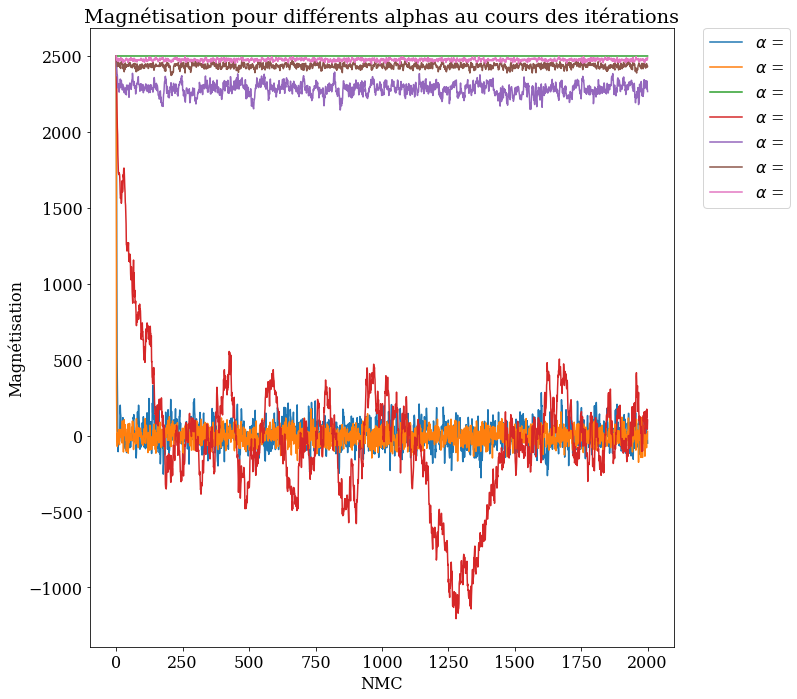

In [8]:
"""il faudrait encore réussir à avoir une légende avec les différents alphas"""
fig, ax=plt.subplots(figsize=(10,10))
NMC_array=np.linspace(0,nx,ny)
index_alpha2=[0.2,0,3,0.4,0.5,0.6,0.7]
for i,j in enumerate(index_alpha2):
    sp2=np.ones([nx,ny])
    states_alpha=ising_model_metropolis(sp2, NMC, nx, ny, j)
    #print(states_alpha)

    plt.plot(states_alpha.sum(axis=(1,2)),label=r"$\alpha$ =")#index_alpha[i])
plt.legend()
handles, labels = ax.get_legend_handles_labels()
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'NMC')
plt.ylabel(r'Magnétisation')
plt.title(r'Magnétisation pour différents alphas au cours des itérations')

plt.tight_layout()

In [9]:
def mean_energy (length,nx,ny, NMC, states_tot, index_alpha):
    energy_alpha=[]
    for i in range(length):
        energy_tot=0
        alpha=index_alpha[i]
        if 0.35<alpha<0.55:
            NMC_start=300   #600
        else:
            NMC_start=50
        current_alpha=states_tot[i]
        for k in range(NMC_start, NMC_start+700):   #800
            current_state=current_alpha[k]
            for n in range(nx):
                for j in range(ny):
                    ener=energy_at_site(current_state,alpha,current_state[n,j],n,j)
                    energy_tot=energy_tot+ener
        energy_alpha.append(energy_tot/(2*NMC))
    return energy_alpha

In [10]:
energy_alpha_end=mean_energy(length,nx,ny,NMC, states_tot, index_alpha)

In [11]:
def mean_magnetisation(length, nx, ny, NMC, states_tot, index_alpha):
    mag_alpha=[]
    for i in range(length):
        mag_tot=0
        alpha=index_alpha[i]
        if 0.35<alpha<0.55:
            NMC_start=300  #600
        else:
            NMC_start=50
        current_alpha=states_tot[i]
        for k in range(NMC_start, NMC_start+700):     #800
            current_state=current_alpha[k]
            for n in range(nx):
                for j in range(ny):
                    mag=current_state[n,j]
                    mag_tot=mag_tot+mag
        mag_alpha.append(mag_tot/(NMC))
    return mag_alpha

In [12]:
mag_alpha_end= mean_magnetisation(length,nx,ny,NMC, states_tot, index_alpha)

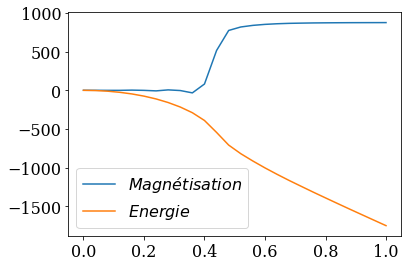

In [13]:
plt.figure()
plt.plot(index_alpha,mag_alpha_end, label=r'$Magnétisation$')
plt.plot(index_alpha,energy_alpha_end, label=r'$Energie$')
plt.legend()
plt.tight_layout()